In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
import expipe
import os
import neo
import pathlib
import numpy as np
import elephant as el
import exdir
from scipy.interpolate import interp1d
import pandas as pd
import sys
sys.path.append('../mec_theta')
import spatial_maps as sp
import data_processing as dp
import optogenetics as og
import quantities as pq
import pycwt
import exdir.plugins.quantities

import spikeextractors as se
import spiketoolkit as st
import numpy as np
import matplotlib.pylab as plt
import place_stimulation as ps
import expipe
import scipy.signal as ss
import pyintan
from trackunitmulticomparison import TrackMultipleSessions

%matplotlib notebook

def find_fmax_noise(recording_hp, start_frame=0, end_frame=300000, start_freq=2000, end_freq=4000):
    import scipy.signal as ss
    filt_traces = recording_hp.get_traces(start_frame=start_frame, end_frame=end_frame)
    f, p = ss.welch(filt_traces, recording_hp.get_sampling_frequency())
    idxs = np.where((f > start_freq) & (f < end_freq))

    max_freq = f[idxs][np.squeeze(p[:, idxs]).mean(axis=0).argmax()]
    return max_freq

In [8]:
plt.rcParams['figure.figsize'] = (9, 6)

In [9]:
project_path = dp.project_path()

project = expipe.get_project(project_path)
actions = project.actions

In [131]:
actions

In [153]:
action = actions['137-190121-2']

In [154]:
check_hp = False
check_lfp = True

In [155]:
data_path = ps.get_data_path(action)

Project path: D:\projects\novel-env
Data path: actions\137-190121-2\data\main.exdir


In [156]:
exdir_file = exdir.File(str(data_path))
acquisition = exdir_file['acquisition']

In [157]:
attrs = acquisition.attrs

In [158]:
prb_file = 'probes/tetrode_32_openephys.prb'
recording = se.OpenEphysRecordingExtractor(str(acquisition[attrs['session']].directory))

Loading Open-Ephys: reading settings...
Decoding data from  binary  format
Reading oebin file


In [159]:
fs = 30000
fs_lfp = 1000
start_time = 60    # in seconds
end_time = 300

In [160]:
tetrode = 1
channel_ids = tetrode*4 + np.arange(4)
print(channel_ids)

[4 5 6 7]


In [161]:
if check_hp:
    traces = recording_rm.get_traces(start_frame=start_time*fs, end_frame=end_time*fs)
    traces_f = recording_f.get_traces(start_frame=start_time*fs, end_frame=end_time*fs)
    timestamps = np.arange(traces.shape[1])/recording.get_sampling_frequency() + start_time
    print(traces.shape, timestamps.shape)

In [162]:
if check_hp:
    plt.figure()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    for i, ch in enumerate(channel_ids):
        plt.plot(timestamps, traces[ch] + 600*i, lw=0.5, color=colors[i])
        plt.plot(timestamps, traces_f[ch] + 600*i, lw=0.5, color=colors[i], alpha=0.3)
        if intan:
            [plt.axvline(d, lw=0.3, alpha=0.2) for d in dig_intan[1].times[::2]]

In [163]:
recording_lfp = st.preprocessing.bandpass_filter(
            recording, freq_min=1, freq_max=300)
recording_lfp = st.preprocessing.resample(
    recording_lfp, 1000)
fs_lfp = 1000

In [164]:
if check_lfp:
    traces_lfp = recording_lfp.get_traces(start_frame=start_time*fs_lfp, end_frame=end_time*fs_lfp)
    timestamps_lfp = np.arange(traces_lfp.shape[1])/recording_lfp.get_sampling_frequency() + start_time
    f, p = ss.welch(traces_lfp, fs=fs_lfp, nperseg=2048)

<IPython.core.display.Javascript object>


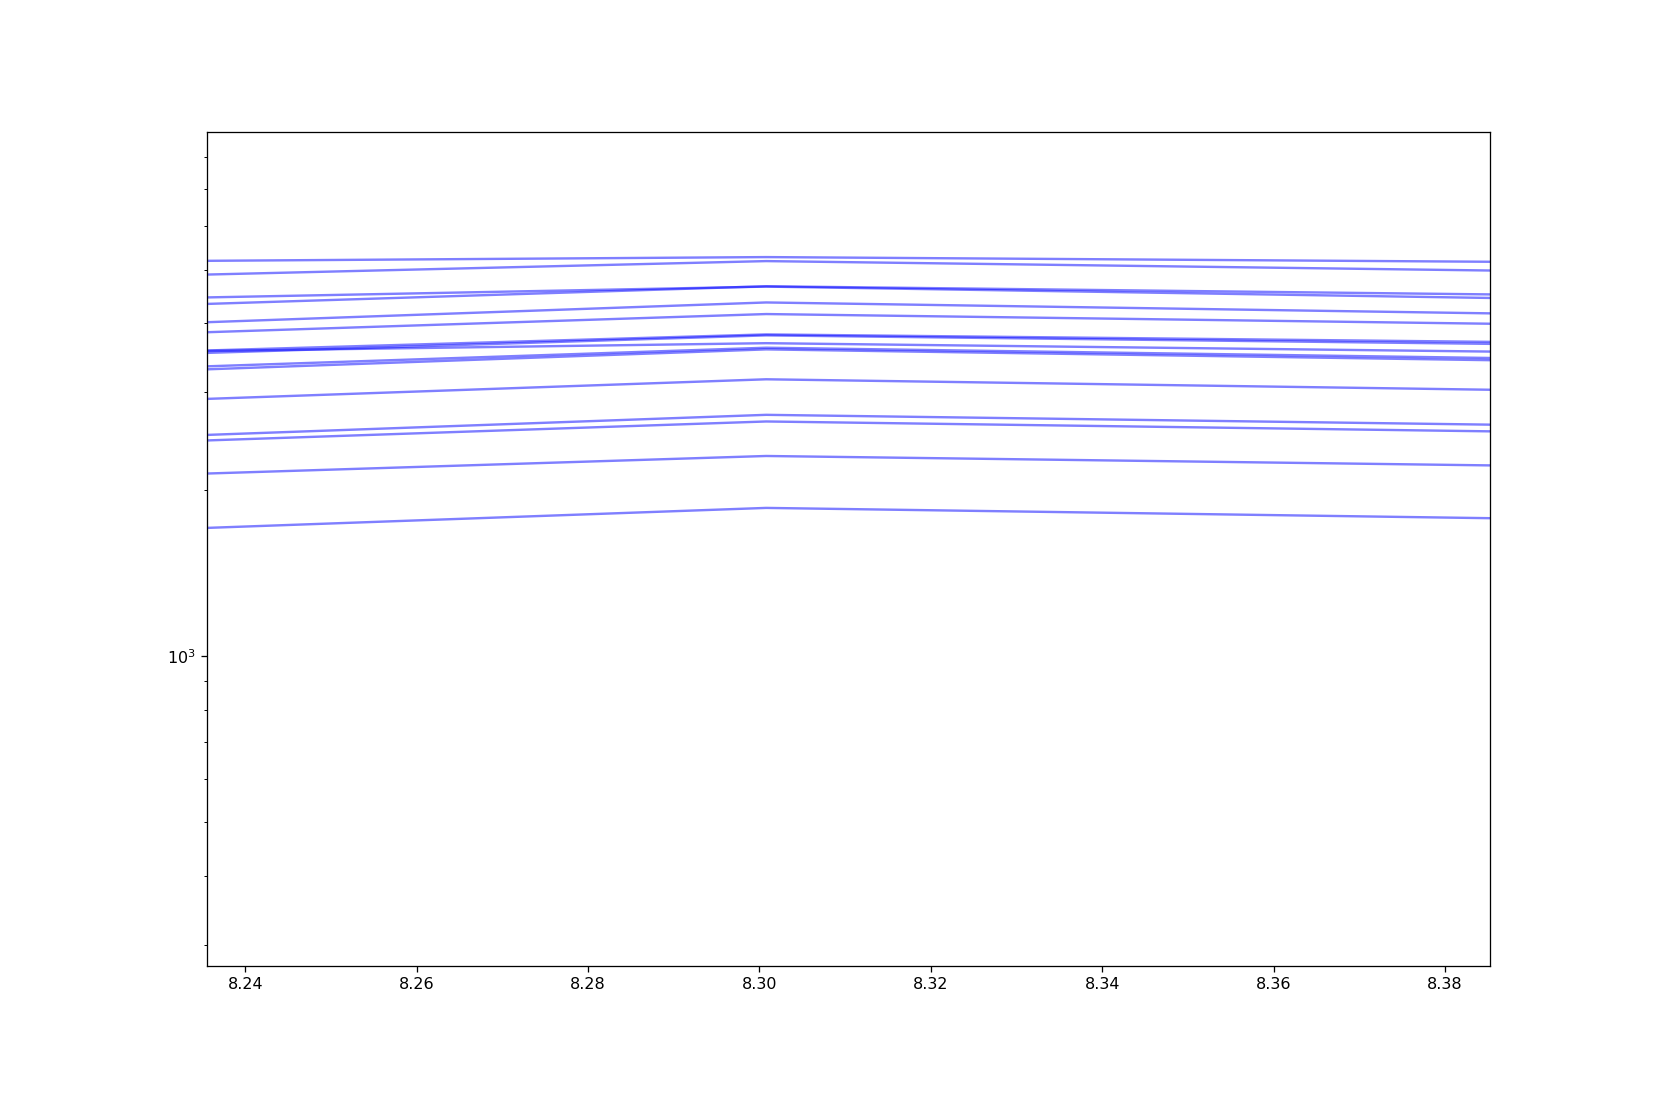

In [165]:
if check_lfp:
    plt.figure()
    f_idx_100 = np.where(f < 100)
    f_100 = f[f_idx_100]
    p_100 = np.squeeze(p[:, f_idx_100])
#     _ = plt.semilogy(f_100, p_100[:16].T, 'r', alpha=0.5) #tetrodes 0-3
    _ = plt.semilogy(f_100, p_100[16:].T, 'b', alpha=0.5) #tetrodes 4-7



In [166]:
lfp = np.array(traces_lfp)
lfp.shape

(32, 240000)

In [167]:
channel = 2

data = np.mean(lfp, axis=0)
    
sampling_rate = 1000

sampling_period = 1 / sampling_rate

times = np.arange(0, data.shape[0] / sampling_rate, 1 / sampling_rate)

<IPython.core.display.Javascript object>


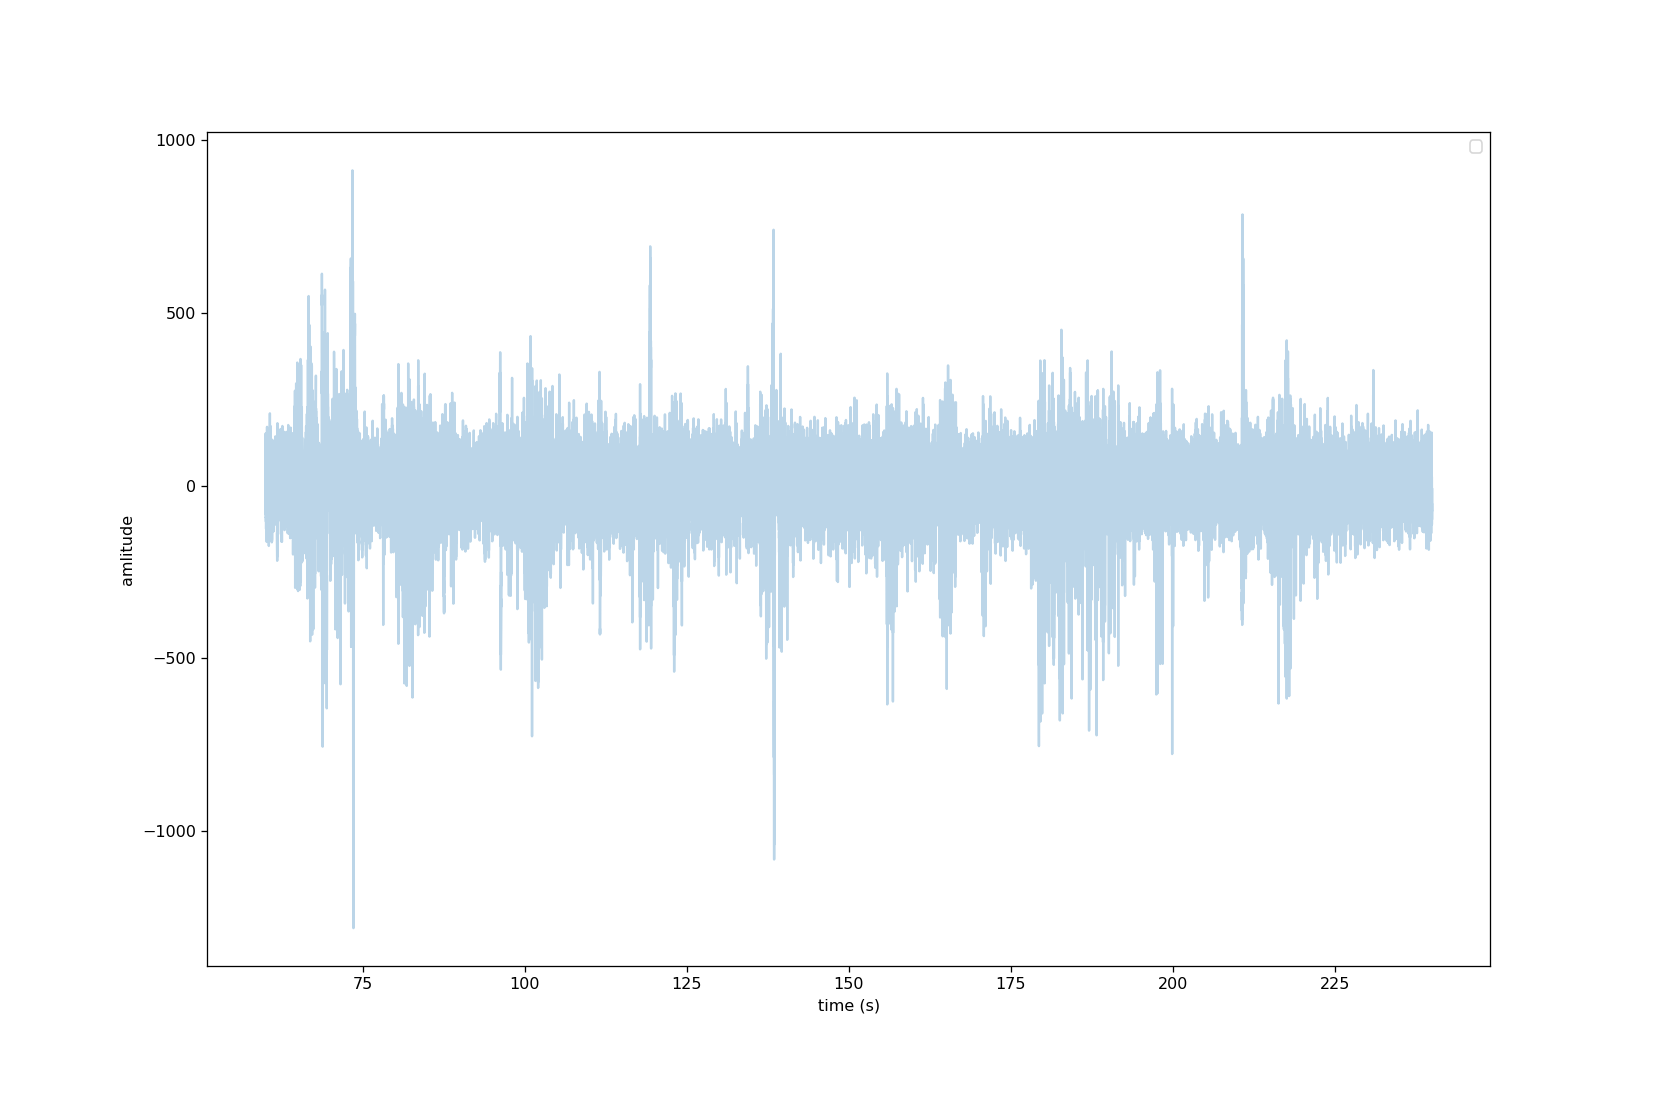

No handles with labels found to put in legend.


In [168]:
start_time = 60
stop_time = 300

mask = (start_time < times) & (times < stop_time) # seconds
plt.figure()
plt.plot(times[mask], data[mask], alpha=.3)
plt.ylabel('amlitude')
plt.xlabel('time (s)')
plt.legend()

<IPython.core.display.Javascript object>


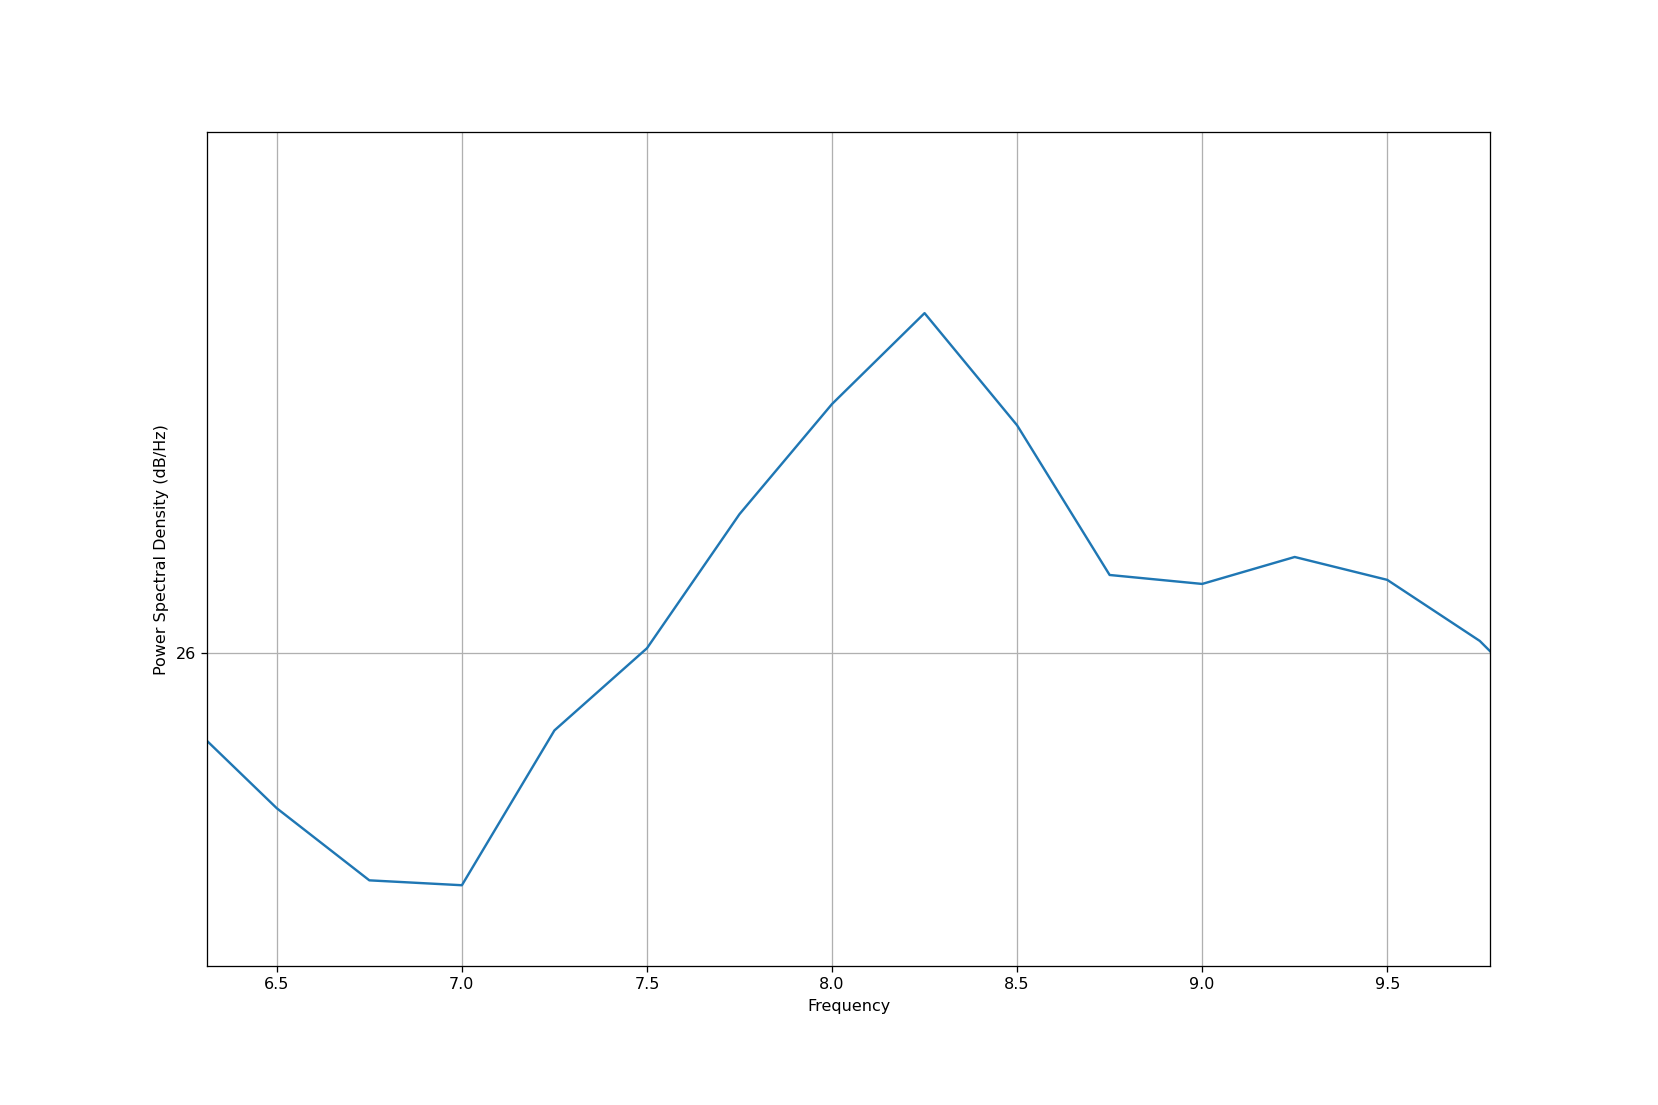

(0.0, 50.0)

In [172]:
start_time = 60
stop_time = 300

#make this exclusively for tetrodes 0-3 (psd above says peak rmec<8.5 and lmec=10, here says 8.5)
mask = (start_time < times) & (times < stop_time) # seconds

plt.figure()
plt.psd(data[mask], Fs=sampling_rate, NFFT=4000)
plt.xlim(0,50)

In [170]:
def mask_coi(power, freqs, coi):
    periods = 1 / freqs
    for i in range(power.shape[1]):
        mask = periods > coi[i]
        power[mask, i] = np.nan

<IPython.core.display.Javascript object>


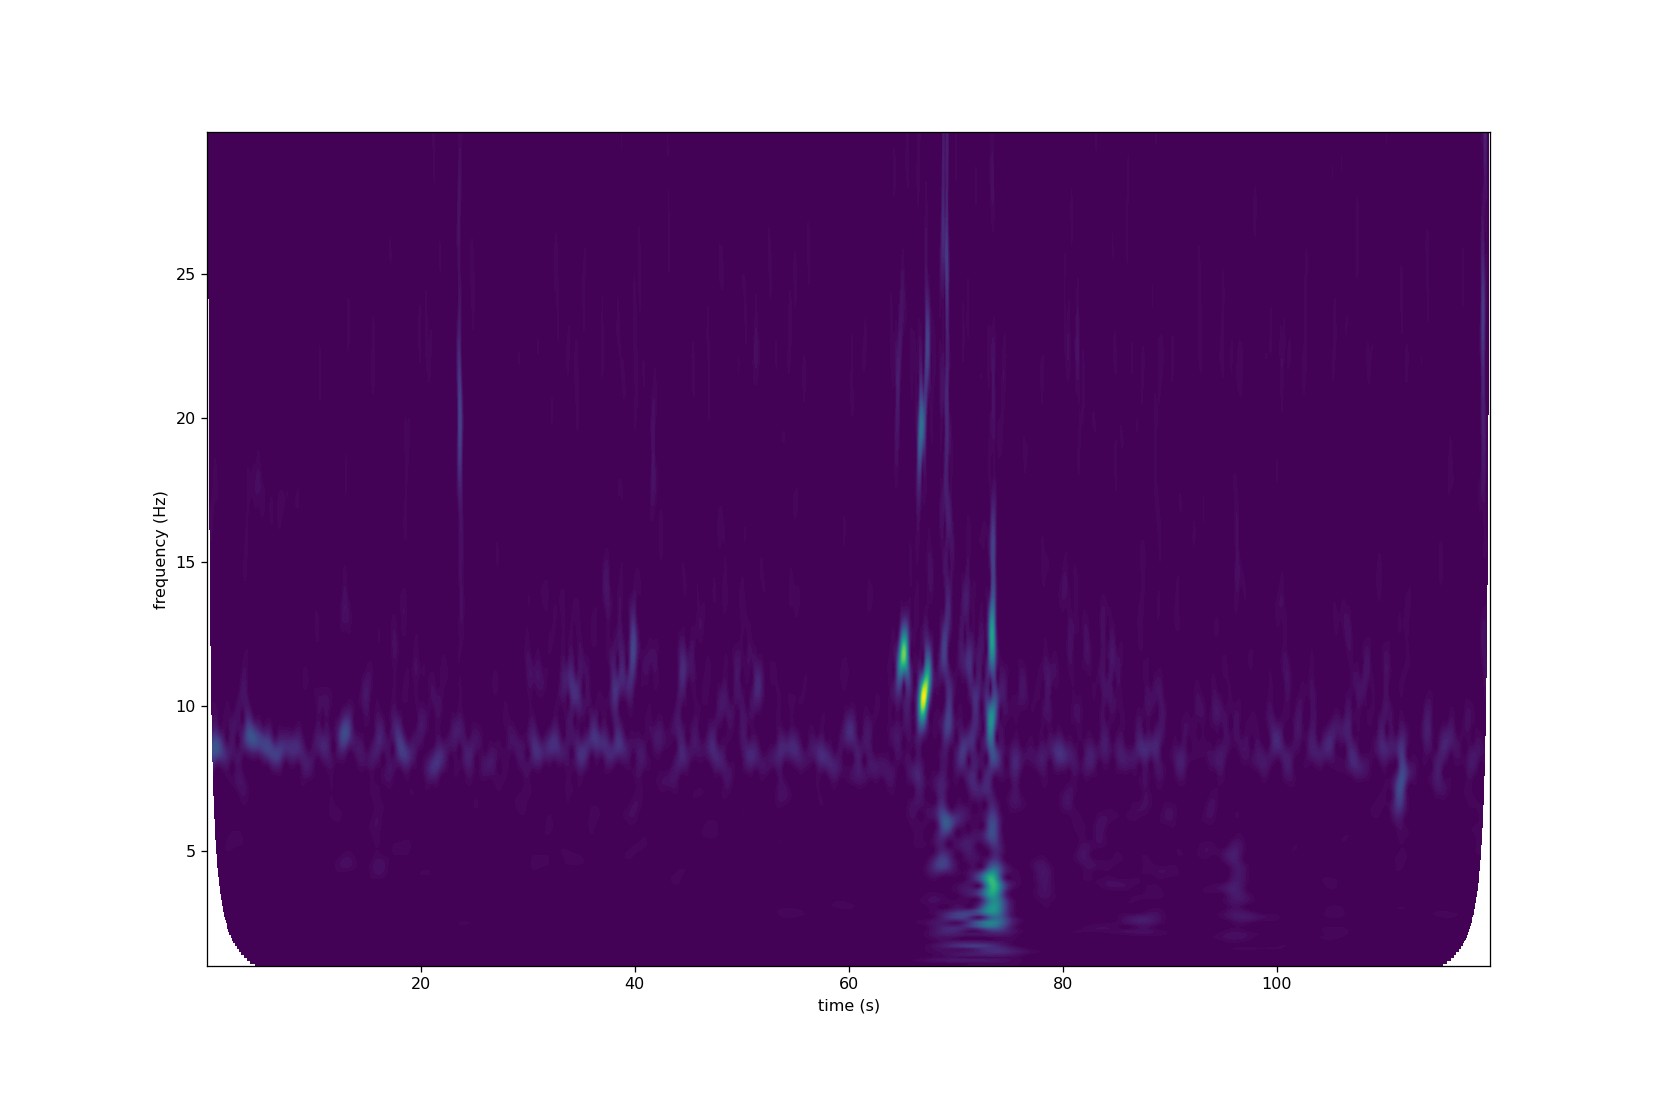

Text(0.5, 0, 'time (s)')

In [171]:
start_time = 0
stop_time = 120

mask = (start_time < times) & (times < stop_time) # seconds

mother = pycwt.Morlet(20) # Morlet size
freqs = np.arange(1, 30, .1) # Frequency range

wave, scales, freqs, coi, fft, fftfreqs = pycwt.cwt(data[mask], sampling_period, freqs=freqs, wavelet=mother)

power = (np.abs(wave)) ** 2
power /= scales[:, None] #rectify the power spectrum according to suggestions proposed by Liu et al. (2007)

mask_coi(power, freqs, coi)

plt.figure()
plt.contourf(times[mask], freqs, power, levels=100)
    
plt.ylabel('frequency (Hz)')
plt.xlabel('time (s)')